<a href="https://colab.research.google.com/github/lokeshdonthi/AI-DRIVEN-FRAUD-DETECTION-AND-TRANSACTION-OPTIMIZATION-IN-PAYMENT-SYSTEMS/blob/main/Copy_of_SDP_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow

In [ ]:
!pip install opencv-python-headless

In [ ]:
from google.colab import drive
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import normalize
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, confusion_matrix, roc_auc_score, roc_curve,
    average_precision_score, precision_recall_curve,
    precision_recall_fscore_support, cohen_kappa_score,
    matthews_corrcoef, balanced_accuracy_score
)
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input as vgg_preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input as resnet_preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input as inception_preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input as mobilenet_preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array

warnings.filterwarnings("ignore")

# Mount Google Drive
drive.mount('/content/drive')

drive_path = "/content/drive/My Drive/QR_Images"
benign_folder = os.path.join(drive_path, "benign_qr_images_500")
malicious_folder = os.path.join(drive_path, "malicious_qr_images_500")

# Verify if the folders exist
if not os.path.exists(benign_folder) or not os.path.exists(malicious_folder):
    print("[ERROR] One or both dataset folders are missing!")
    print("Check your Google Drive path and folder structure.")
else:
    print("[SUCCESS] Dataset folders found!")


Mounted at /content/drive
[SUCCESS] Dataset folders found!


In [ ]:
# Set seed
global_seed = 42
random.seed(global_seed)
np.random.seed(global_seed)


In [ ]:
def load_images_sift(folder, label, img_size=128):
    data = []
    files = sorted(os.listdir(folder))
    for fname in files:
        path = os.path.join(folder, fname)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"[WARNING] Could not load image: {path}")
            continue
        img_resized = cv2.resize(img, (img_size, img_size))
        data.append((img_resized, label, fname))
    return data


In [ ]:
def load_images_deep(folder, label, img_size=224):
    data = []
    files = sorted(os.listdir(folder))
    for fname in files:
        path = os.path.join(folder, fname)
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        if img is None:
            print(f"[WARNING] Could not load image: {path}")
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_resized = cv2.resize(img, (img_size, img_size))
        data.append((img_resized, label, fname))
    return data

def extract_morph_features(img):
    return np.array([0.0, 0.0], dtype=np.float32)

def build_bovw(descriptor_list, num_clusters=100):
    all_desc = np.vstack(descriptor_list)
    kmeans = MiniBatchKMeans(n_clusters=num_clusters, random_state=global_seed, batch_size=100)
    kmeans.fit(all_desc)
    histograms = []
    for desc in descriptor_list:
        if desc is None or len(desc) == 0:
            hist = np.zeros(num_clusters, dtype=np.float32)
        else:
            cluster_ids = kmeans.predict(desc)
            hist, _ = np.histogram(cluster_ids, bins=np.arange(num_clusters+1))
            hist = hist.astype(np.float32)
        histograms.append(hist)
    histograms = normalize(np.array(histograms), norm='l2')
    return kmeans, histograms

def evaluate_model(svm, X_test, y_test):
    y_pred = svm.predict(X_test)
    y_proba = svm.predict_proba(X_test)[:, 1]
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    avg_precision = average_precision_score(y_test, y_proba)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
    kappa = cohen_kappa_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    fpr, tpr, roc_thresholds = roc_curve(y_test, y_proba)
    pr_precision, pr_recall, pr_thresholds = precision_recall_curve(y_test, y_proba)
    cm = confusion_matrix(y_test, y_pred)
    return {
        "accuracy": acc, "auc": auc, "average_precision": avg_precision,
        "precision": precision, "recall": recall, "f1": f1,
        "cohen_kappa": kappa, "matthews_corrcoef": mcc,
        "balanced_accuracy": balanced_acc, "confusion_matrix": cm,
        "roc": (fpr, tpr, roc_thresholds), "pr_curve": (pr_precision, pr_recall, pr_thresholds)
    }

def plot_individual_results(method_name, metrics):
    fpr, tpr, _ = metrics["roc"]
    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC (AUC={metrics['auc']:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f"ROC Curve - {method_name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

    pr_precision, pr_recall, _ = metrics["pr_curve"]
    plt.figure()
    plt.plot(pr_recall, pr_precision, label=f"Precision-Recall (AP={metrics['average_precision']:.2f})")
    plt.title(f"Precision-Recall Curve - {method_name}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    plt.show()


In [ ]:
results = {}

In [ ]:
def run_sift_pipeline():
    print("Running SIFT + BoVW pipeline...")
    data = load_images_sift(benign_folder, 0) + load_images_sift(malicious_folder, 1)
    sift = cv2.SIFT_create()
    descriptors_list, labels, morph_feats = [], [], []
    for (img, lbl, _) in data:
        kp, desc = sift.detectAndCompute(img, None)
        if desc is None or len(desc) == 0:
            desc = np.zeros((1, 128), dtype=np.float32)
        descriptors_list.append(desc)
        labels.append(lbl)
        morph_feats.append(extract_morph_features(img))

    morph_feats = np.array(morph_feats)
    _, bovw = build_bovw(descriptors_list, num_clusters=100)
    features = np.hstack((bovw, morph_feats))
    labels = np.array(labels)

    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2,
                                                        stratify=labels, random_state=global_seed)
    svm = SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=global_seed)
    svm.fit(X_train, y_train)
    metrics = evaluate_model(svm, X_test, y_test)
    results["SIFT + BoVW"] = metrics
    print("[SIFT] Accuracy:", metrics["accuracy"])
    plot_individual_results("SIFT + BoVW", metrics)


Running SIFT + BoVW pipeline...
[SIFT] Accuracy: 0.83


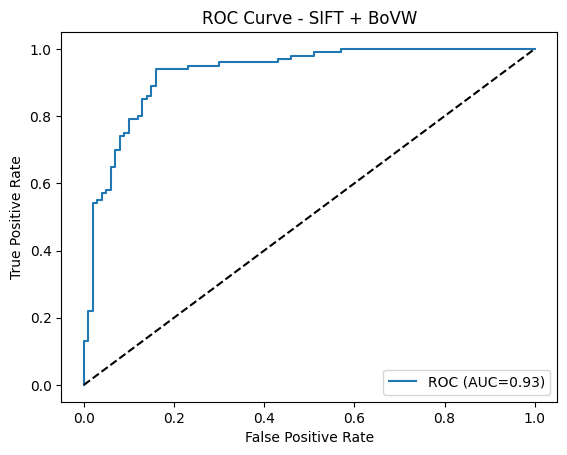

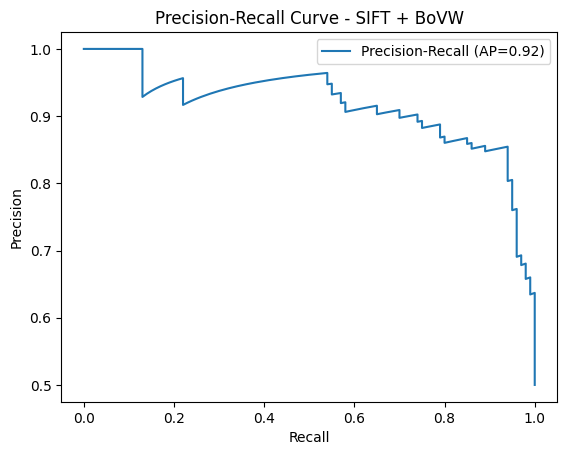

In [ ]:
run_sift_pipeline()

In [ ]:
def run_orb_pipeline():
    print("Running ORB + BoVW pipeline...")
    data = load_images_sift(benign_folder, 0) + load_images_sift(malicious_folder, 1)
    orb = cv2.ORB_create(nfeatures=500)
    descriptors_list, labels, morph_feats = [], [], []
    for (img, lbl, _) in data:
        kp, desc = orb.detectAndCompute(img, None)
        if desc is None or len(desc) == 0:
            desc = np.zeros((1, 32), dtype=np.float32)
        else:
            desc = np.float32(desc)
        descriptors_list.append(desc)
        labels.append(lbl)
        morph_feats.append(extract_morph_features(img))

    morph_feats = np.array(morph_feats)
    _, bovw = build_bovw(descriptors_list, num_clusters=100)
    features = np.hstack((bovw, morph_feats))
    labels = np.array(labels)

    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2,
                                                        stratify=labels, random_state=global_seed)
    svm = SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=global_seed)
    svm.fit(X_train, y_train)
    metrics = evaluate_model(svm, X_test, y_test)
    results["ORB + BoVW"] = metrics
    print("[ORB] Accuracy:", metrics["accuracy"])
    plot_individual_results("ORB + BoVW", metrics)


Running ORB + BoVW pipeline...
[ORB] Accuracy: 0.65


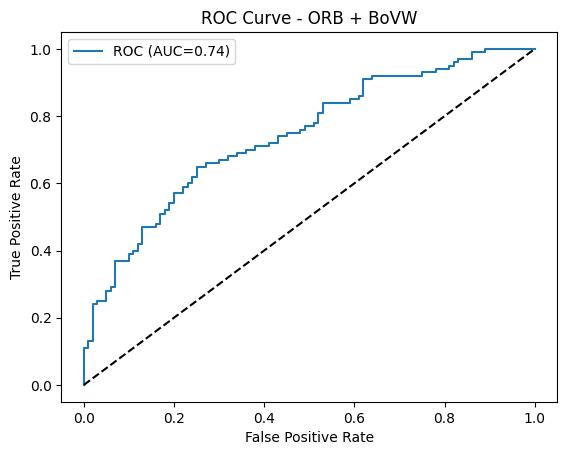

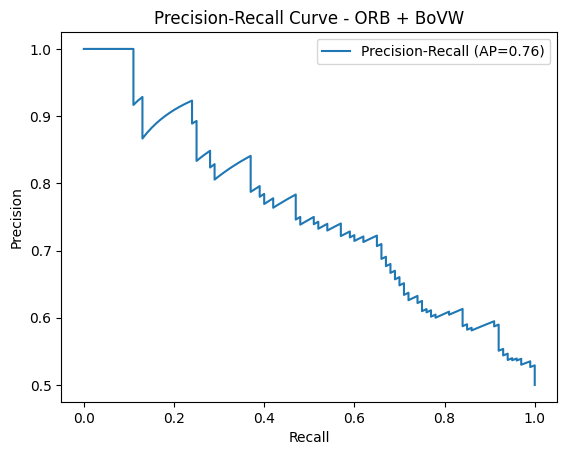

In [ ]:
run_orb_pipeline()

In [ ]:
def run_vgg16_pipeline():
    print("Running VGG16 feature extraction pipeline...")
    data = load_images_deep(benign_folder, 0) + load_images_deep(malicious_folder, 1)
    model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    features, labels = [], []

    for (img, label, _) in data:
        arr = img_to_array(img)
        arr = np.expand_dims(arr, axis=0)
        arr = vgg_preprocess_input(arr)
        feat = model.predict(arr, verbose=0).flatten()
        features.append(feat)
        labels.append(label)

    features = np.array(features)
    labels = np.array(labels)

    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2,
                                                        stratify=labels, random_state=global_seed)
    svm = SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=global_seed)
    svm.fit(X_train, y_train)
    metrics = evaluate_model(svm, X_test, y_test)
    results["VGG16"] = metrics
    print("[VGG16] Accuracy:", metrics["accuracy"])
    plot_individual_results("VGG16", metrics)


Running VGG16 feature extraction pipeline...
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
[VGG16] Accuracy: 0.85


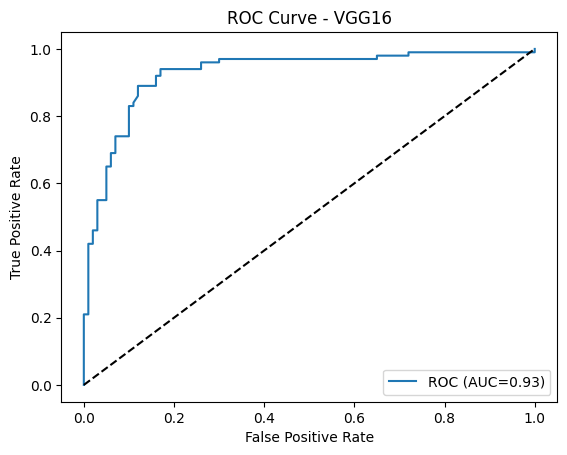

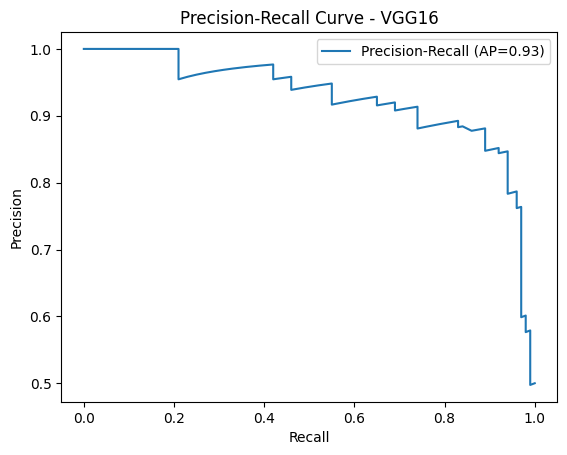

In [ ]:
run_vgg16_pipeline()

In [ ]:
def run_resnet50_pipeline():
    print("Running ResNet50 feature extraction pipeline...")
    data = load_images_deep(benign_folder, 0) + load_images_deep(malicious_folder, 1)
    model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    features, labels = [], []

    for (img, label, _) in data:
        arr = img_to_array(img)
        arr = np.expand_dims(arr, axis=0)
        arr = resnet_preprocess_input(arr)
        feat = model.predict(arr, verbose=0).flatten()
        features.append(feat)
        labels.append(label)

    features = np.array(features)
    labels = np.array(labels)

    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2,
                                                        stratify=labels, random_state=global_seed)
    svm = SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=global_seed)
    svm.fit(X_train, y_train)
    metrics = evaluate_model(svm, X_test, y_test)
    results["ResNet50"] = metrics
    print("[ResNet50] Accuracy:", metrics["accuracy"])
    plot_individual_results("ResNet50", metrics)


Running ResNet50 feature extraction pipeline...
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
[ResNet50] Accuracy: 0.825


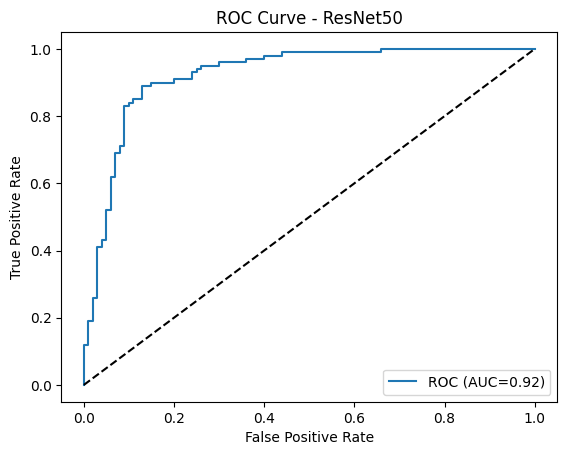

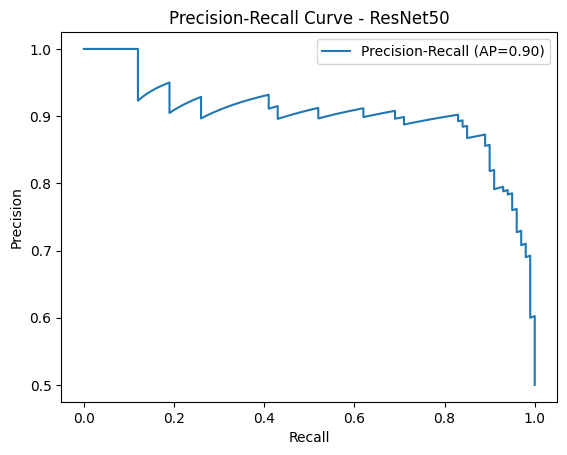

In [ ]:
run_resnet50_pipeline()

In [ ]:
def run_inception_pipeline():
    print("Running InceptionV3 feature extraction pipeline...")
    data = load_images_deep(benign_folder, 0) + load_images_deep(malicious_folder, 1)
    model = InceptionV3(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    features, labels = [], []

    for (img, label, _) in data:
        arr = img_to_array(img)
        arr = np.expand_dims(arr, axis=0)
        arr = inception_preprocess_input(arr)
        feat = model.predict(arr, verbose=0).flatten()
        features.append(feat)
        labels.append(label)

    features = np.array(features)
    labels = np.array(labels)

    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2,
                                                        stratify=labels, random_state=global_seed)
    svm = SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=global_seed)
    svm.fit(X_train, y_train)
    metrics = evaluate_model(svm, X_test, y_test)
    results["InceptionV3"] = metrics
    print("[InceptionV3] Accuracy:", metrics["accuracy"])
    plot_individual_results("InceptionV3", metrics)


Running InceptionV3 feature extraction pipeline...
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
[InceptionV3] Accuracy: 0.825


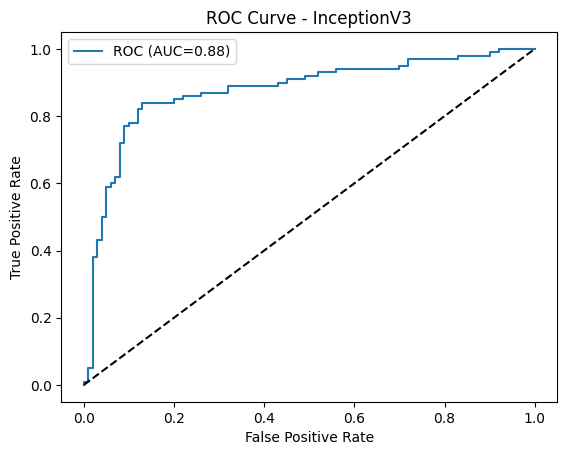

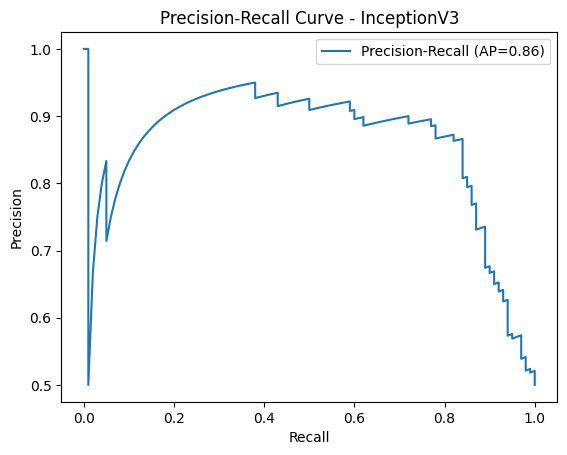

In [ ]:
run_inception_pipeline()

In [ ]:
def run_mobilenet_pipeline():
    print("Running MobileNetV2 feature extraction pipeline...")
    data = load_images_deep(benign_folder, 0) + load_images_deep(malicious_folder, 1)
    model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    features, labels = [], []

    for (img, label, _) in data:
        arr = img_to_array(img)
        arr = np.expand_dims(arr, axis=0)
        arr = mobilenet_preprocess_input(arr)
        feat = model.predict(arr, verbose=0).flatten()
        features.append(feat)
        labels.append(label)

    features = np.array(features)
    labels = np.array(labels)

    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2,
                                                        stratify=labels, random_state=global_seed)
    svm = SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=global_seed)
    svm.fit(X_train, y_train)
    metrics = evaluate_model(svm, X_test, y_test)
    results["MobileNetV2"] = metrics
    print("[MobileNetV2] Accuracy:", metrics["accuracy"])
    plot_individual_results("MobileNetV2", metrics)


Running MobileNetV2 feature extraction pipeline...
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
[MobileNetV2] Accuracy: 0.825


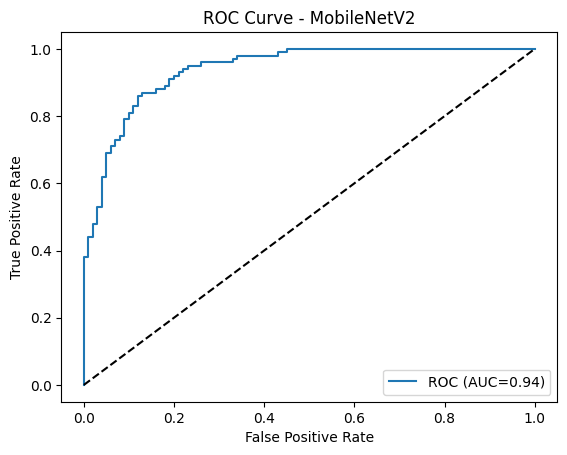

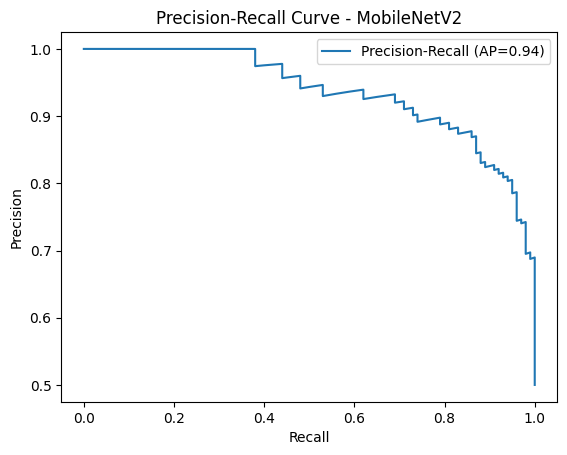

In [ ]:
run_mobilenet_pipeline()

=== Summary of Advanced Metrics ===
             accuracy     auc  average_precision  precision  recall        f1  \
SIFT + BoVW     0.830  0.9287           0.916478   0.892857    0.75  0.815217   
ORB + BoVW      0.650  0.7417           0.757268   0.633929    0.71  0.669811   
VGG16           0.850  0.9274           0.926597   0.888889    0.80  0.842105   
ResNet50        0.825  0.9225           0.902871   0.891566    0.74  0.808743   
InceptionV3     0.825  0.8757           0.856599   0.891566    0.74  0.808743   
MobileNetV2     0.825  0.9391           0.936750   0.891566    0.74  0.808743   

             cohen_kappa  matthews_corrcoef  balanced_accuracy  
SIFT + BoVW         0.66           0.668614              0.830  
ORB + BoVW          0.30           0.302184              0.650  
VGG16               0.70           0.703526              0.850  
ResNet50            0.65           0.659601              0.825  
InceptionV3         0.65           0.659601              0.825  
Mobile

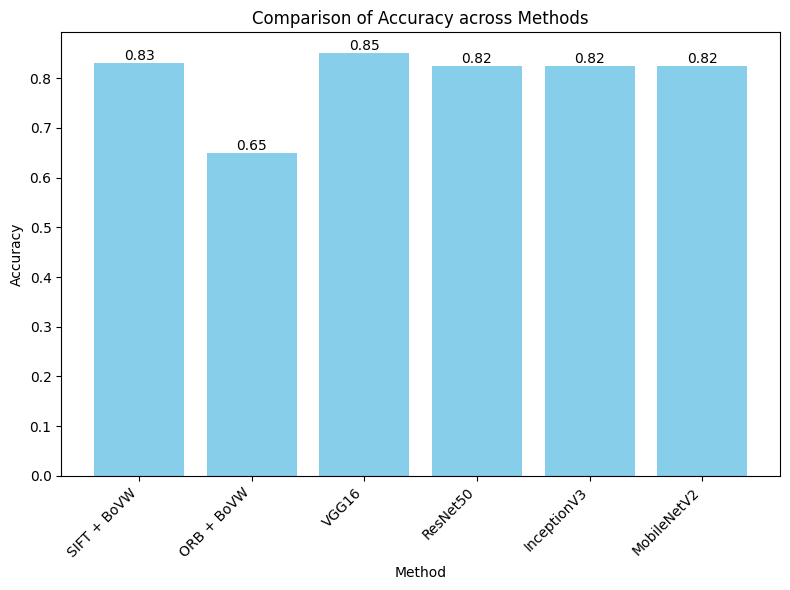

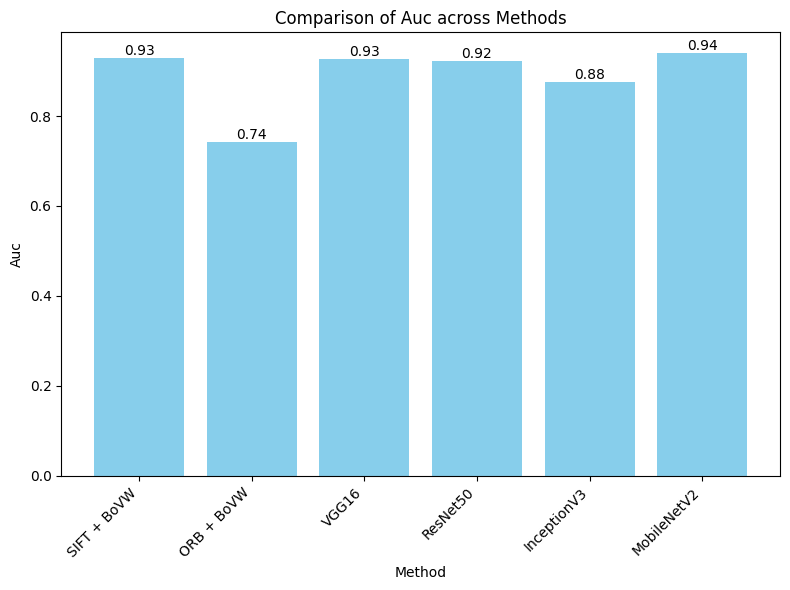

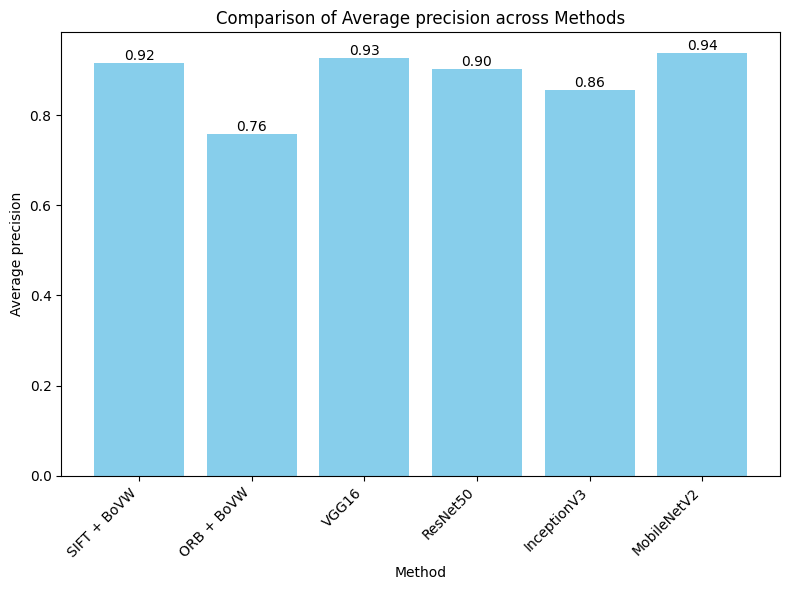

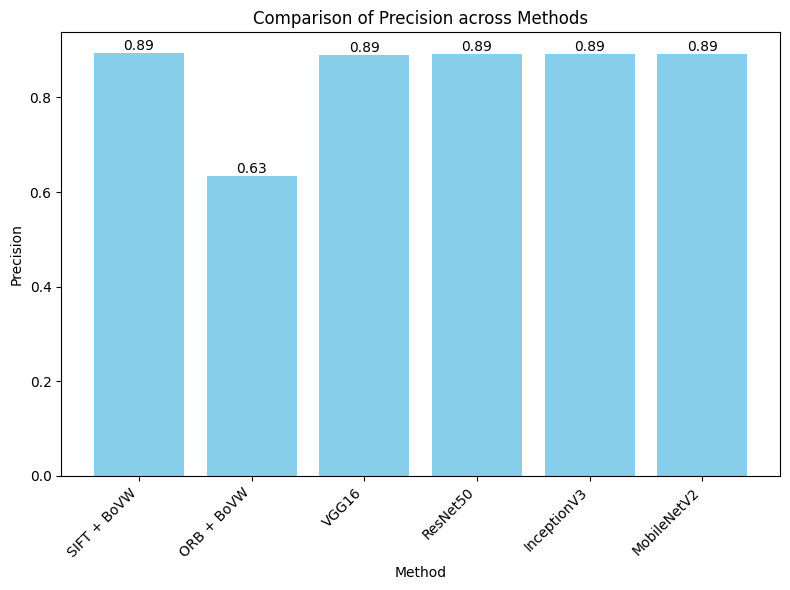

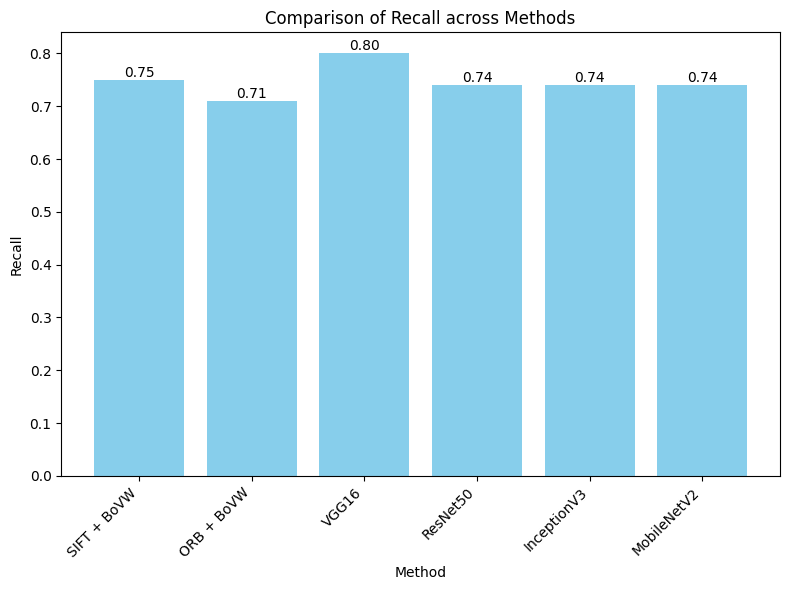

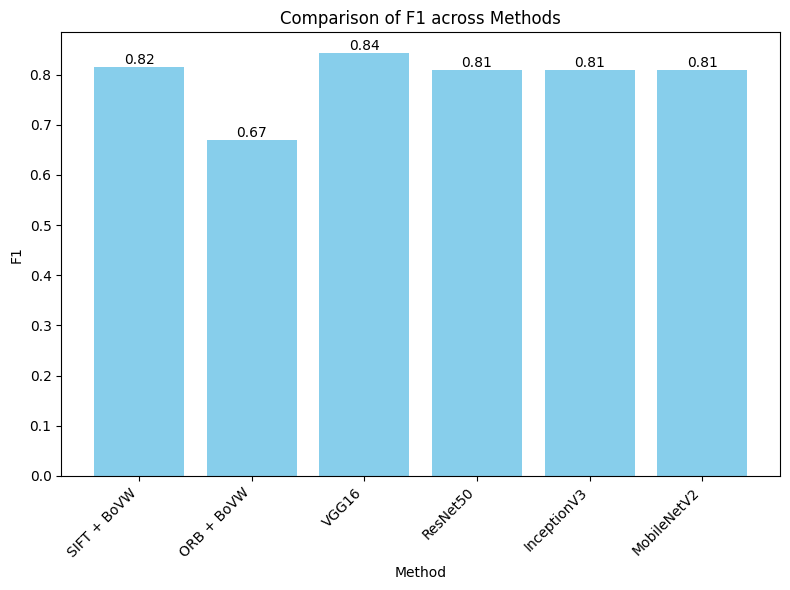

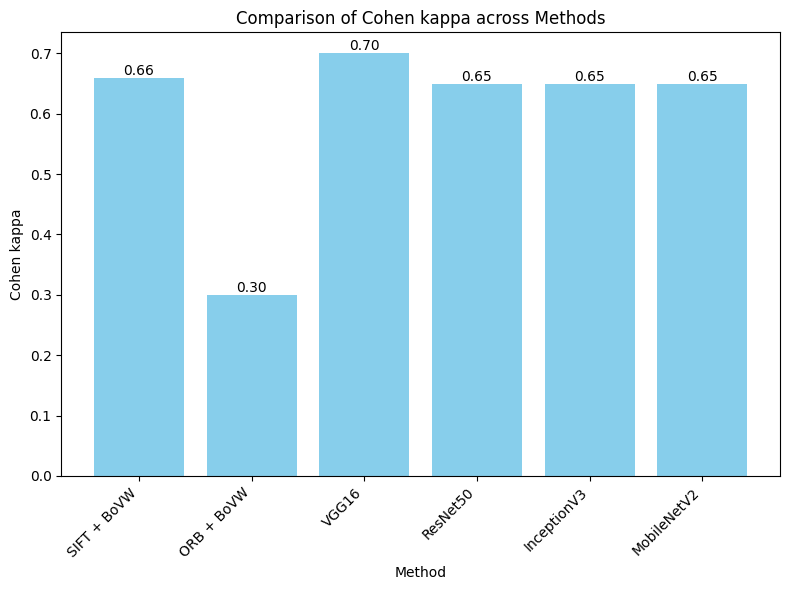

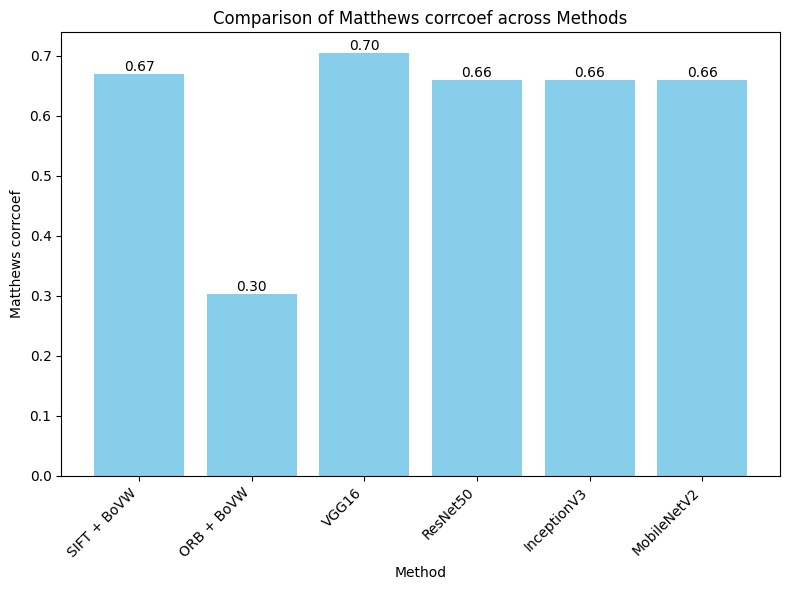

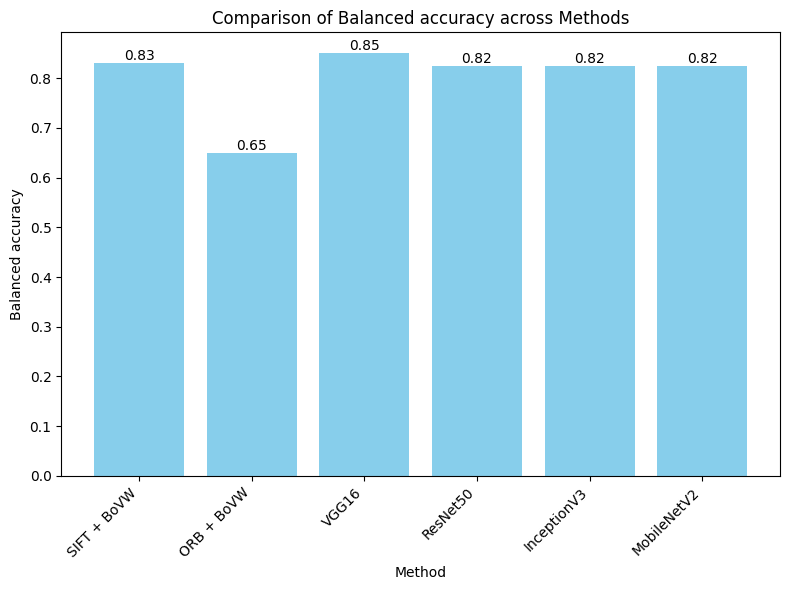

=== Confusion Matrix Summary ===
             TN  FP  FN  TP
SIFT + BoVW  91   9  25  75
ORB + BoVW   59  41  29  71
VGG16        90  10  20  80
ResNet50     91   9  26  74
InceptionV3  91   9  26  74
MobileNetV2  91   9  26  74


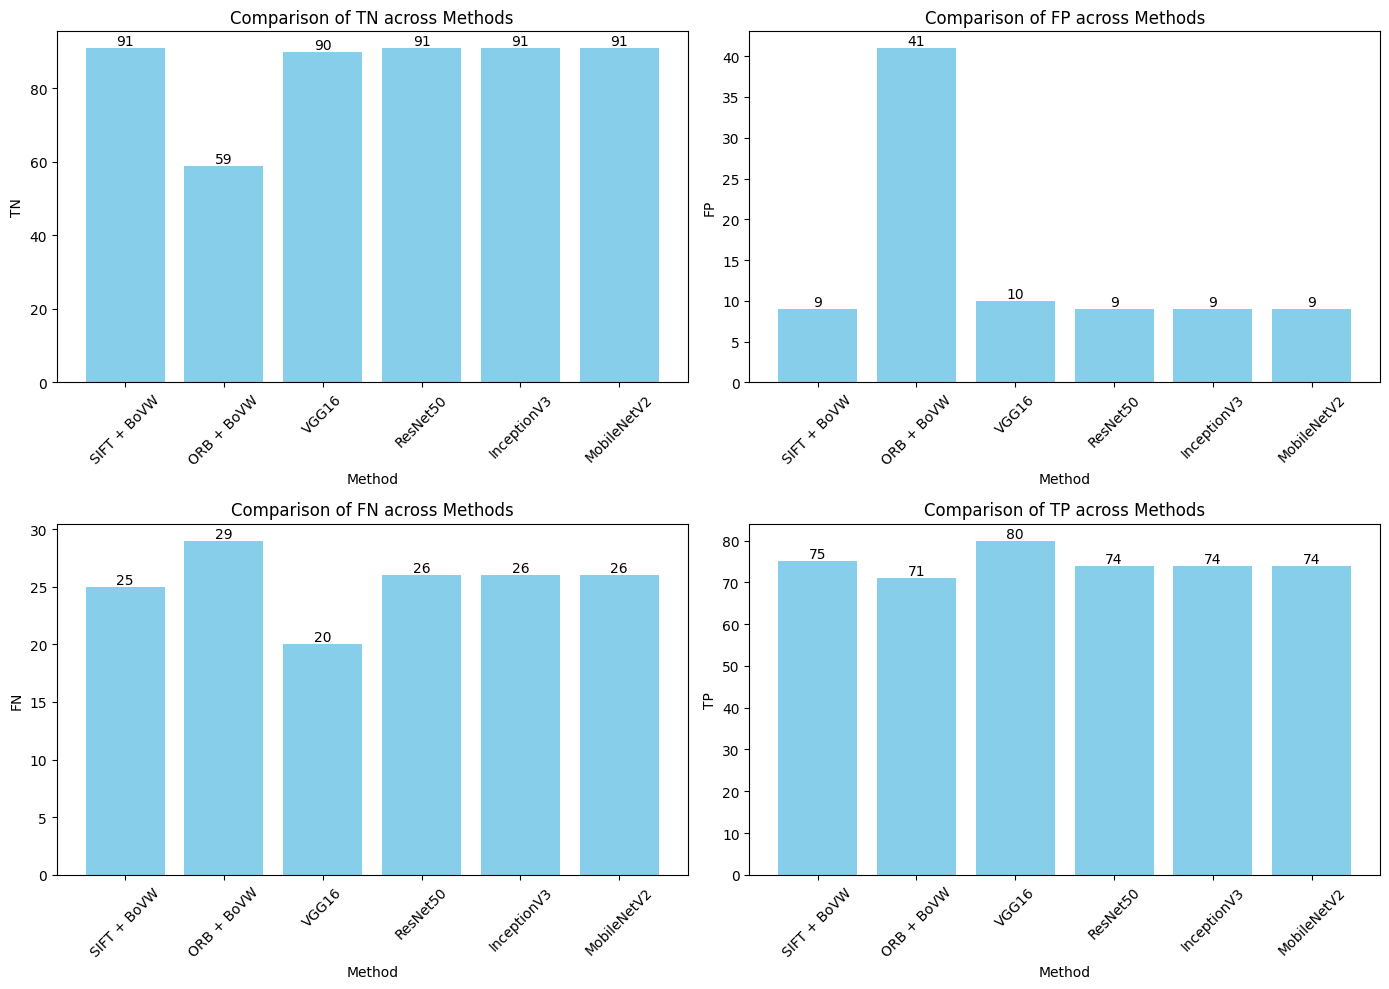

In [ ]:
# ## Summary & Comparative Analysis
# Generate a DataFrame of advanced classification metrics across all methods.

import pandas as pd

metric_names = [
    "accuracy", "auc", "average_precision", "precision", "recall", "f1",
    "cohen_kappa", "matthews_corrcoef", "balanced_accuracy"
]

summary = {metric: [] for metric in metric_names}
methods_available = list(results.keys())

for method in methods_available:
    for metric in metric_names:
        summary[metric].append(results[method][metric])

df_summary = pd.DataFrame(summary, index=methods_available)
print("=== Summary of Advanced Metrics ===")
print(df_summary)


# ### Visualize Advanced Metrics Across Methods


for metric in metric_names:
    plt.figure(figsize=(8, 6))
    values = summary[metric]
    bars = plt.bar(methods_available, values, color='skyblue')
    plt.xlabel("Method")
    plt.ylabel(metric.replace("_", " ").capitalize())
    plt.title(f"Comparison of {metric.replace('_',' ').capitalize()} across Methods")
    plt.xticks(rotation=45, ha="right")
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.2f}', va='bottom', ha='center')
    plt.tight_layout()
    plt.show()

# Summarize confusion matrix components: TN, FP, FN, TP
cm_summary = {"TN": [], "FP": [], "FN": [], "TP": []}

for method in methods_available:
    cm = results[method]["confusion_matrix"]
    cm_summary["TN"].append(cm[0, 0])
    cm_summary["FP"].append(cm[0, 1])
    cm_summary["FN"].append(cm[1, 0])
    cm_summary["TP"].append(cm[1, 1])

df_cm = pd.DataFrame(cm_summary, index=methods_available)
print("=== Confusion Matrix Summary ===")
print(df_cm)

# ### Visualize Confusion Matrix Components

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()
categories = ["TN", "FP", "FN", "TP"]

for i, cat in enumerate(categories):
    ax = axes[i]
    bars = ax.bar(methods_available, df_cm[cat].values, color='skyblue')
    ax.set_xlabel("Method")
    ax.set_ylabel(cat)
    ax.set_title(f"Comparison of {cat} across Methods")
    ax.tick_params(axis='x', rotation=45)
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2.0, yval, f'{int(yval)}', va='bottom', ha='center')

plt.tight_layout()
plt.show()
